<a href="https://colab.research.google.com/github/nsoma97/conv_ai/blob/main/Conversational_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependenciák telepítése

In [1]:
# tensorflow warning-jai nagyon zavaróak, ezért kikapcsoljuk:
%%sh
export AUTOGRAPH_VERBOSITY=0

**Dependenciák**
* Rasa: nyílt forráskódú chatbot keretrendszer
* nest_asyncio: szükségünk lesz arra, hogy aszinkron feladatokat indítsunk el a notebookban
* https://github.com/oroszgy/spacy-hungarian-models - nem hivatalos magyar nyelvű Spacy modellek

In [2]:
!pip install rasa==1.10.3
!pip install nest_asyncio==1.3.3
!pip install https://github.com/oroszgy/spacy-hungarian-models/releases/download/hu_core_ud_lg-0.3.1/hu_core_ud_lg-0.3.1-py3-none-any.whl  

     |████████████████████████████████| 512kB 18.6MB/s 
     |████████████████████████████████| 1.3MB 43.3MB/s 
     |████████████████████████████████| 512kB 44.9MB/s 
     |████████████████████████████████| 184kB 36.7MB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
     |████████████████████████████████| 421.9MB 23kB/s 
     |████████████████████████████████| 112kB 49.9MB/s 
     |████████████████████████████████| 266kB 48.5MB/s 
     |████████████████████████████████| 419kB 44.6MB/s 
     |████████████████████████████████| 3.2MB 24.8MB/s 
     |████████████████████████████████| 153kB 51.4MB/s 
     |████████████████████████████████| 1.6MB 39.6MB/s 
     |████████████████████████████████| 450kB 48.0MB/s 
     |████████████████████████████████| 61kB 6.2MB/s 
     |████████████████████████████████| 133kB 50.5MB/s 
     |████████████████████████████████| 378kB 48.0MB/s 
     |████████████████████████████████| 102kB 10.3MB/s 
     |████████████████████████████████| 153kB 39.7MB

ERROR: nbclient 0.5.3 has requirement jupyter-client>=6.1.5, but you'll have jupyter-client 5.3.5 which is incompatible.
  Found existing installation: nest-asyncio 1.5.1
    Uninstalling nest-asyncio-1.5.1:
      Successfully uninstalled nest-asyncio-1.5.1
     |████████████████████            | 834.1MB 1.2MB/s eta 0:06:58tcmalloc: large alloc 1147494400 bytes == 0x5582e9cd2000 @  0x7f0b4ae53615 0x5582afb9506c 0x5582afc74eba 0x5582afb97e8d 0x5582afc8999d 0x5582afc0bfe9 0x5582afc06b0e 0x5582afb9977a 0x5582afc0be50 0x5582afc06b0e 0x5582afb9977a 0x5582afc0886a 0x5582afc8a7c6 0x5582afc07ee2 0x5582afc8a7c6 0x5582afc07ee2 0x5582afc8a7c6 0x5582afc07ee2 0x5582afc8a7c6 0x5582afd0c431 0x5582afc6d049 0x5582afbd7c84 0x5582afb988e9 0x5582afc0cade 0x5582afb9969a 0x5582afc07a45 0x5582afc06e0d 0x5582afb9977a 0x5582afc07a45 0x5582afb9969a 0x5582afc07a45
     |█████████████████████████▎      | 1055.7MB 1.4MB/s eta 0:03:19tcmalloc: large alloc 1434370048 bytes == 0x55832e328000 @  0x7f0b4ae53615 0x5582a

Linkeljük a letöltött magyar Spacy modelleket a `hu` kulcsszóhoz, ezután már Spacy-ből is közvetlenül használhatjuk majd.

In [3]:
!python3 -m spacy link hu_core_ud_lg hu

✔ Linking successful
/usr/local/lib/python3.7/dist-packages/hu_core_ud_lg -->
/usr/local/lib/python3.7/dist-packages/spacy/data/hu
You can now load the model via spacy.load('hu')


# Rasa demo chatbot

Hozzunk létre egy üres demo chatbotot a `create_initial_project` paranccsal. Ez létrehoz egy egyszerű projektet, amiben néhány intent már definiálva van. Ezzel a chatbottal már beszélgethetünk is akár.

In [4]:
import os
import rasa
import tensorflow as _
from rasa.cli.scaffold import create_initial_project
from rasa.jupyter import chat
import nest_asyncio
import warnings

warnings.filterwarnings("ignore")
nest_asyncio.apply()

In [5]:
project = "test-chatbot"
create_initial_project(project) # hozzunk létre egy demo chatbotot

os.chdir(project)

In [6]:
%ls

actions.py  credentials.yml  domain.yml     __init__.py   tests/
config.yml  data/            endpoints.yml  __pycache__/


* **domain.yml**: definiálja az 'univerzumot', melyben a chatbotunk működik. Itt soroljuk fel, hogy milyen felhasználói szándékokat kezelünk, mik az entitásaink, megadhatjuk a lehetséges válaszokat, slotokat, stb...
* **config.yml**: itt határozzuk meg a chatbot által használt NLU pipeline-t, azaz hogy pontosan milyen NLP modulokat alkalmazunk a felhasználó által megaadott bemeneti szövegre
* **actions.py**: itt implementálható egyedi üzleti logika, adatbázis lekérdezés, API hívások megvalósítása, stb.
* **credentials.yml** és **endpoints.yml**: beállítható külső integráció (Slack, Facebook, stb.) a chatbothoz, az elérési pontok megadása
* **tests/**: ebben a mappában teszteseteket írhatunk a chatbot működésének kiértékelésére

* **data/**: itt található a tanítóadatunk
  - **nlu.md**: intentekhez sorolt, entitásokkal annotált tanítómondatok, ebből tanul az NLU model (Rasa NLU)
  - **stories.md**: itt olyan 'sztorikat' írunk le absztrakt formában, amelyek a felhasználóval lejátszódhatnak, ebből tanul a dialógusmodell (Rasa Core)


In [7]:
def training_with_retry(domain, config, training_files, output):
  """
  Colab-on valami megmagyarázhatatlan okból az első két training elszáll...
  """
  model_path = None
  for i in range(3):
    if model_path:
      break

    try:
      model_path = rasa.train(domain, config, [training_files], output)
    except Exception as e:
      print(f'{i+1}. kísérlet sikertelen.')

  if model_path:
    return model_path
  else:
    raise Exception('Model training failed...')

A `rasa.train` parancs hatására a Rasa két dolgot végez el:


* **Core model/dialógusmodell tanulása**: beolvassa a `stories.md` fájlból a sztorikat, `config.yml`-ben megadott stratégiák szerint megtanulja, hogy milyen felhasználói szándékra hogyan kell reagálnia majd a beszélgetések során
* **NLU model tanulása**: megtanulja, hogy az egyes felhasználói inputokat hogyan dolgozza fel, az `nlu.md`-ben megadott tanulómondatok alapján megtanulja, hogy milyen bemenet milyen intentet jelent, milyen entitásokat tartalmaz...



In [8]:
%rm -r models/

rm: cannot remove 'models/': No such file or directory


In [9]:
config = "config.yml"
training_files = "data/"
domain = "domain.yml"
output = "models/"


model_path = training_with_retry(domain, config, training_files, output)
print(model_path)

Training Core model...
1. kísérlet sikertelen.
Training Core model...
2. kísérlet sikertelen.
Training Core model...


Processed trackers: 100%|██████████| 5/5 [00:00<00:00, 118.70it/s, # actions=16]
Processed actions: 16it [00:00, 676.93it/s, # examples=16]
Epochs: 100%|██████████| 100/100 [00:15<00:00,  6.37it/s, t_loss=0.078, loss=0.008, acc=1.000]


Core model training completed.
Training NLU model...


Epochs: 100%|██████████| 100/100 [00:17<00:00,  5.76it/s, t_loss=1.633, i_loss=0.255, i_acc=1.000]


NLU model training completed.
Your Rasa model is trained and saved at '/content/test-chatbot/models/20210425-160552.tar.gz'.
models/20210425-160552.tar.gz


A `chat` paranccsal beszélgethetünk a chatbottal. A `/stop` parancs terminálja a beszélgetést. <br>
A demo chatbot kevés dologra képes, alaphelyzetben a hangulatunkról érdeklődik, illetve képes reagálni az azzal kapcsolatos vádakra, hogy ő valójában nem is ember, hanem egy robot.
<br><br>
(*tipp*: ha eláruljuk a botnak, hogy szomorúak vagyunk, megkísérel felvidítani egy aranyos képpel, de sajnos bugos a notebookos verzió, és a képek megszakítják a beszélgetést. 🙃) 

In [10]:
endpoints = 'endpoints.yml'
chat(model_path, endpoints)

Your bot is ready to talk! Type your messages here or send '/stop'.
hey
Hey! How are you?
I feel great
Great, carry on!
are you a bot?
I am a bot, powered by Rasa.
thanks, bye
Bye
/stop


Ez kezdetnek nem rossz, de ha komolyabb chatbotot szeretnénk, akkor nekünk kell megadnunk a tanító adatot, a kívánt reakciókat, stb...

# Saját, magyarul beszélő chatbot

Hozzunk létre egy chatbotot a Csongrád Megyei Takarékszövetkezet számára!

Azt szeretnénk, hogy a chatbot a következő funkciókat lássa el:
* Reagáljon a bot az üdvözlésre, elköszönésre
* Le lehessen kérdezni a számlaegyenleget (most egy random számot, mondjuk)
* Adjon információt, ha valaki hitelt szeretne felvenni
* Képes legyen befagyasztani a bankkárytánk (ha megkérjük rá)
* Adjon információt a bank közeli automatáiról és bankfiókjairól.
* Ha a felhasználó rákérdez, hogy egy adott bankfiók mikor van nyitva, kérdezze le a nyitvatartást és küldje el neki



In [11]:
%cd /content
%mkdir our-very-own-chatbot
%cd our-very-own-chatbot
%mkdir data

/content
/content/our-very-own-chatbot


## Tanítóadat definiálása

Az `nlu.md`-ben adjunk meg intenteket és hozzájuk tartozó mondatokat, melyekből a chatbot megtanulhatja, hogy később milyen felhasználótól származó bemenethez milyen intentet rendeljen. <br>
Itt adhatunk meg entitásokat is, ld.: `location_open` intent.

In [12]:
%%writefile data/nlu.md

## intent: greeting
    - szia
    - üdv
    - jó napot
    - jó napot kívánok!
    - hello
    - jó estét!
## intent: closure
    - viszlát
    - köszönöm, viszlát
    - köszönöm a segítséget
    - viszontlátásra
    - kössz viszlát
## intent: balance
    - mennyi pénz van a számlámon?
    - mennyi pénzem van?
    - arra vagyok kiváncsi hogy mennyi az egyenlegem
    - hány forint van a számlámon?
    - hány forint az egyenlegem?
    - mutasd az egyenlegem
    - mutasd hogy mennyim van
## intent: credit
    - hitelt szeretnék felvenni
    - kölcsönt szeretnék
    - kölcsönre lenne szükségem
    - banki hitelre lenne szükségem
    - hitelt szeretnék felvenni egy lakásra
    - kölcsönt vennék fel
## intent: freeze_card
    - ellopták a kártyám
    - elveszett a bankkártyám
    - a bankkártyám eltűnt
    - nincs meg a bankkártyám
    - szeretném zárolni a kártyám
    - szeretném befagyasztani a kártyám
    - be szeretném fagyasztani a kártyám
## intent: atm_location
    - hol van a legközelebbi atm?
    - bankautomatát keresek
    - egy automatát keresek
    - mutass egy közeli automatát
    - pénzt szeretnék felvenni
    - készpénzt szeretnék felvenni
    - készpénzre van szükségem
    - hol tudok készpénzt felvenni?
    - mutasd az atmeket
    - egy atm-et keresek
    - hol találok automatát?
    - hol a legközelebbi atm?
    - egy atm kéne
## intent: bank_location
    - hol a legközelebbi fiókotok?
    - egy bankfiókot keresek
    - hol vannak bankfiókjaitok?
    - mutasd a bankok listáját
    - egy bankot keresek
    - legközelebbi bank?
    - közeli bankok listája?
    - hol tudok ügyet intézni?
    - hol található bankfiók?
    - bankfiók helyet keresek
## intent: location_open
    - mi a [szatymazi](bank_location) fiók nyitvatartása?
    - mikor nyit a [szegedi](bank_location) bankotok?
    - mikor tudék bemenni [makón](bank_location) a bankba?
    - mi a nyitvatartási ideje a [szegeden](bank_location) lévő fióknak?
    - nyitva van holnap a [makói](bank_location) fiókuk?
    - mikor nyit holnap a bank [szegeden](bank_location)?
    - meddig van nyitva a bank [szatymazon](bank_location)?
    - mi a [szegedi](bank_location) fiók nyitvatartási ideje?
    - nyitva van még a bank [szatymazon](bank_location)?
    - bezárt már a [makói](bank_location) fiókuk?
    - meddig vannak nyitva a fiókjaik?
    - mi a nyitvatartási idejük?
    - mikor érhető el az ügyfélszolgálatuk?
    - mi az ügyfélszolgálat nyitvatartási ideje?

Writing data/nlu.md


Adjunk meg felhasználói sztorikat, a bot ebből tanulja a dialógus modellt. Ezáltal fogja tudni, hogy milyen válaszokat kell adnia az egyes felhasználói kérésekre.
<br>
Szorik formája:
```
## Sztori neve
* ezt a szándékot detektáljuk a felhasználótól
  - a bot erre így reagál
```



In [13]:
%%writefile data/stories.md

## intro
* greeting
  - utter_greeting

## balance
* greeting
  - utter_greeting
* balance
  - action_get_balance

## balance 1
* balance
  - action_get_balance

## credit
* greeting
  - utter_greeting
* credit
  - utter_credit
* closure
  - utter_closure

## bank_data
* greeting
  - utter_greeting
* bank_location
  - utter_bank_location
* closure
  - utter_closure

## bank_data
* greeting
  - utter_greeting
* bank_location
  - utter_bank_location
* closure
  - utter_closure

## freeze_card_1
* freeze_card
  - utter_freeze_card
* bank_location
  - utter_bank_location
* closure
  - utter_closure

## freeze_card_2
* greeting
  - utter_greeting
* freeze_card
  - utter_freeze_card

## freeze_card_3
* atm_location
  - utter_atm_location
* freeze_card
  - utter_freeze_card
* closure
  - utter_closure

## credit
* credit
  - utter_credit
* bank_location
  - utter_bank_location
* closure
  - utter_closure

## atm_loc_greeting
* greeting
  - utter_greeting
* atm_location
  - utter_atm_location
* closure
  - utter_closure

## atm_loc
* atm_location
  - utter_atm_location

## bank_open
* location_open {"bank_location": "makó"}
  - action_location_open

## bank_open_1
* greeting
  - utter_greeting
* location_open {"bank_location": "makó"}
  - action_location_open

## bank_open 2
* location_open {"bank_location": "makói"}
  - action_location_open

## bank_open 3
* location_open {"bank_location": "szeged"}
  - action_location_open

## bank_open 4
* location_open {"bank_location": "szatymaz"}
  - action_location_open

## bank_open 5
* location_open {"bank_location": "szegeden"}
  - action_location_open

## bank_open 5
* location_open {"bank_location": "szegedi"}
  - action_location_open

Writing data/stories.md


A `domain.yml`-ben a chatbot univerzumát határozzuk meg, mindent itt adunk meg ami a beszélgetésben értelmezett. Felsoroljuk az intenteket, a bot válaszait, az akciókat, stb...

In [14]:
%%writefile domain.yml

entities: 
  - bank_location

intents: 
  - greeting
  - closure
  - balance
  - credit
  - freeze_card
  - atm_location
  - bank_location
  - location_open

templates: 
  utter_atm_location: 
    - text: "Az ATM-eink a következő felületen kereshetők: www.csongraditakarek.hu/atms"
  utter_bank_location: 
    - text: "Jelenleg három bankfiókkal rendelkezünk: Szegeden, Makón és Szatymazon."
  utter_closure: 
    - text: "Viszlát!"
  utter_credit: 
    - text: "Hiteligényléshez kérjük keresse fel egyik fiókunkat! Az elérhető információkról a honlapunkon tájékozódhat."
  utter_freeze_card: 
    - text: "Kártyáját azonnali hatállyal befagyasztottuk. További információért keresse ügyintézőinket."
  utter_greeting: 
    - text: "Üdvözlöm! Miben segíthetek?"

actions:
  - action_location_open
  - action_get_balance
  - utter_greeting
  - utter_closure
  - utter_balance
  - utter_credit
  - utter_freeze_card
  - utter_atm_location
  - utter_bank_location

Writing domain.yml


Szükség lehet azonban arra, hogy a bot bonyolultabb üzleti logikát valósítson meg egy-egy felhasználói inputra. Ilyenkor kóddal adhatjuk meg, hogy mit csináljon a bot.
<br>
Esetünkben két komplexebb feladata van a botnak:
*   lekérdezni, hogy melyik bankfiók mikor van nyitva
*   lekérdezni a felhasználó számlaegyenlegét

Esetünkben egyszerű statikus választ adunk az első esetben és egy 0-100,000 közti random számot a másodikban, de könnyen látható, hogy ebben a lépésben bármilyen API hívást, adatbázis lekérdezést megvalósíthatnánk...


In [15]:
%%writefile actions.py

from random import randint
from typing import Any, Text, Dict, List

from rasa_sdk import Action, Tracker
from rasa_sdk.executor import CollectingDispatcher

class ActionLocationOpen(Action):

    def name(self) -> Text:
        return "action_location_open"

    def run(self, dispatcher: CollectingDispatcher, tracker: Tracker, domain: Dict[Text, Any]) -> List[Dict[Text, Any]]:
        """
        Kérdezzük le az egyes bankokhoz a nyitvatartást
        """
        if tracker.latest_message['entities']:
          # megkapjuk az entitást, amit kinyert az NLU pipeline a felhasználó üzenetéből
          # ezután megnézzük, hogy melyik bankfiók helyszín van az entitásban és annak függvényében válaszolunk

          entity = tracker.latest_message['entities'][0]['value']
          if 'szeged' in entity.lower():
            dispatcher.utter_message(text=f'A szegedi bankunk 0-24 órában nyitva tart.')
          elif 'mak' in entity.lower():
            dispatcher.utter_message(text=f'A makói bankunk hétköznapokon reggel 9-től este 6-ig tart nyitva.')
          elif 'szatymaz' in entity.lower():
            dispatcher.utter_message(text=f'A szatymazi bankunk hétköznapokon és szombaton reggel 7-től este 8-ig tart nyitva.')
        else:
          dispatcher.utter_message(text='A bankfiókok nyitvatartása elérhető itt: www.csongratitakarek.hu/nyitvatartas')

        return []


class ActionGetBalance(Action):

    def name(self) -> Text:
        return "action_get_balance"

    def run(self, dispatcher: CollectingDispatcher, tracker: Tracker, domain: Dict[Text, Any]) -> List[Dict[Text, Any]]:
        """
        Adjuk vissza a számlaegyenleget
        """
        balance = f'{randint(0,100000):,}'
        dispatcher.utter_message(text=f'Egyenleged: {balance} Ft')

        return []

Writing actions.py


## Modell tanítása

Tanítsuk meg a botot, hogy értse a felhasználói üzeneteket és a sztorikban látottakhoz hasonlóan tudjon viselkedni! <br>
Adjuk meg a következő NLU pipelinet:

In [16]:
%%writefile config.yml

language: hu

pipeline:
  - name: SpacyNLP
  - name: SpacyTokenizer
  - name: SpacyFeaturizer
  - name: CountVectorsFeaturizer
  - name: DIETClassifier
    epochs: 100
    entity_recognition: true

policies:
   - name: MemoizationPolicy
   - name: TEDPolicy
     max_history: 5
     epochs: 100

Writing config.yml


De mit is csinál ez pontosan?

`language: hu` -> a notebook elején linkeltük a magyar nyelvű Spacy modelleket a `hu` kulcsszó alá, a Rasa ott fogja keresni majd

**pipeline**: -> NLP lépések egy sorozata, amit minden input szövegen elvégzünk
* **SpacyNLP** - inicializálja a Spacy-t
* **SpacyTokenizer** - tokenizálja a bejövő üzenetet a Spacy tokenizálójával (részletek: https://rasa.com/docs/rasa/components/#spacytokenizer)
* **SpacyFeaturizer** - beolvassa az egyes szavakhoz a vektoros reprezentációkat, alap beállítással átlagolással (mean pooling) kiszámolja a teljes bemenethez tartozó vektoros jellemzőt (részletek: https://rasa.com/docs/rasa/components/#spacytokenizer)
* **CountVectorsFeaturizer** - a tokenek alapján számoljunk le egy szózsákos reprezentációt is (részletek: https://rasa.com/docs/rasa/components/#countvectorsfeaturizer)
* **DIETClassifier** - intentek és entitások együttes kinyerését végző mélytanuló architektúra, bemenete: sűrű (
  a Spacy-s dokumentum vektorok) és/vagy a ritka (szózsákos) vektorok (részletek: https://rasa.com/docs/rasa/components#dietclassifier és https://arxiv.org/pdf/2004.09936.pdf)

**policies**: -> stratégiákat adunk meg a bot számára, hogy milyen lépéseket tegyen bizonyos felhasználói inputokra
* **MemoizationPolicy** - megjegyzi a megadott sztorikat, ha olyan beszélgetésmintával találkozunk, ami része a sztoriknak visszaadja az ott megadott szükséges akciót (Részletek: https://rasa.com/docs/rasa/policies/#memoization-policy)
* **TED policy** - gépi tanulási alapon predikálja a szükséges következő akciót, ha nem része az input a sztoriknak (Részletek: https://rasa.com/docs/rasa/policies/#ted-policy)



In [17]:
%rm models/ -r

rm: cannot remove 'models/': No such file or directory


In [18]:
config = "config.yml"
training_files = "data/"
domain = "domain.yml"
output = "models/"

model_path = rasa.train(domain, config, [training_files], output)
print(model_path)

Processed Story Blocks:   0%|          | 0/19 [00:00<?, ?it/s]

Training Core model...


Processed trackers: 100%|██████████| 13/13 [00:00<00:00, 117.68it/s, # actions=43]
Processed actions: 43it [00:00, 660.02it/s, # examples=43]
Epochs: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s, t_loss=0.070, loss=0.001, acc=1.000]


Core model training completed.
Training NLU model...


Epochs: 100%|██████████| 100/100 [00:29<00:00,  3.38it/s, t_loss=0.755, i_loss=0.100, entity_loss=0.039, i_acc=1.000, entity_f1=0.633]


NLU model training completed.
Your Rasa model is trained and saved at '/content/our-very-own-chatbot/models/20210425-160918.tar.gz'.
models/20210425-160918.tar.gz


## NLU modell kiértékelése

Értékeljük ki az imént tanított NLU pipelinet, hogy képet kapjunk arról, milyen pontos lesz előreláthatólag a bot majd "production"-ben, vannak-e a felhasználói input értelmezésnek gyenge pontjai...

In [19]:
# kicsomagolom az imént tanított modellt, ehhez kiírom előbb a nevét környezeti változónak, hogy parancssorból elérjem
os.environ['model_path'] = model_path.split('/')[-1]

In [20]:
%%sh
echo A modellem neve pedig:
echo $model_path
echo
echo Csomagoljuk ki...
cd models
mkdir latest_model
tar -xf $model_path -C latest_model
ls latest_model/nlu

A modellem neve pedig:
20210425-160918.tar.gz

Csomagoljuk ki...
checkpoint
component_3_CountVectorsFeaturizer.pkl
component_4_DIETClassifier.data_example.pkl
component_4_DIETClassifier.entity_tag_specs.json
component_4_DIETClassifier.index_label_id_mapping.pkl
component_4_DIETClassifier.label_data.pkl
component_4_DIETClassifier.tf_model.data-00000-of-00001
component_4_DIETClassifier.tf_model.index
metadata.json


Olyan mondatokon célszerű kiértékelni a modellt, amelyeket nem látott a tanítás során. Gyűjtsünk ilyeneket a `test_nlu.md` fájlba.

In [21]:
%%writefile test_nlu.md

## intent: greeting
    - üdvözlöm
    - hali
    - jó reggelt kívánok
    - hej
## intent: closure
    - köszönöm a segítséget, viszlát
    - viszont hallásra
    - további szép napot
    - kössz, ennyit akartam csak
## intent: balance
    - mennyi a számlaegyenlegem?
    - megtudhatom hogy hány forint van a számlámon?
    - azt szeretném tudni, hogy mennyi pénzem van
    - mennyi pénz van a kártyámon?
## intent: credit
    - banki kölcsönre van szükségem
    - lakáscélú hitel érdekelne
    - milyen törlesztőrészlettel tudnak hitelt adni?
    - kölcsönt szeretnék felvenni egy autóra
## intent: freeze_card
    - fagyasszák be a kártyám kérem
    - a bankkártyám ellopták, mit tudnánk tenni?
    - zároljuk a kártyám
    - zárolni kéne a kártyám, szerintem ellopták
## intent: atm_location
    - mutass egy közeli atm-et
    - egy bank automatát keresek ahol pénzt vehetek fel
    - bankautomatát keresek
    - hol vannak atmek?
## intent: bank_location
    - mutass egy közeli bankot
    - hol vannak fiókjai a banknak?
    - hol találom a legközelebbi fiókot?
    - bankfiókot keresek
## intent: location_open
    - milyen idősávban tart nyitva a bank [szegeden](bank_location)?
    - a [makói](bank_location) fiók nyitvarartása érdekelne
    - most zárva taart épp a [szatymazi](bank_location) fiók?
    - a [makói](bank_location) nyitva van épp?
    - nyitva vannak most?
    - a [szatymazi](bank_location) fiók nyitvatartása?
    - mi a nyitvatartás [szegeden](bank_location)?

Writing test_nlu.md


Futtassuk a kiértékelést a tanult modellel a fent megadott teszt adaton:

In [22]:
evaluation_output = rasa.nlu.test(data_path='test_nlu.md', model_path='models/latest_model/nlu')

Instructions for updating:
Use tf.identity instead.


100%|██████████| 35/35 [00:02<00:00, 12.20it/s]


Nézzük meg, hogy milyen felhasználói inputra milyen intentet predikált a bot.

In [23]:
import pandas as pd

eval_df = pd.DataFrame(evaluation_output['intent_evaluation']['predictions'])
eval_df

,text,intent,predicted,confidence
0,üdvözlöm,greeting,greeting,0.505515
1,hali,greeting,freeze_card,0.323020
2,jó reggelt kívánok,greeting,greeting,0.938327
3,hej,greeting,greeting,0.733292
4,"köszönöm a segítséget, viszlát",closure,closure,0.998397
5,viszont hallásra,closure,bank_location,0.609324
6,további szép napot,closure,greeting,0.980338
7,"kössz, ennyit akartam csak",closure,freeze_card,0.419189
8,mennyi a számlaegyenlegem?,balance,balance,0.958290
9,megtudhatom hogy hány forint van a számlámon?,balance,balance,0.999557


Irassuk ki az intent szintű hibametrikákat. (Elég kevés az adat, de azért talán valami látszik...)

In [24]:
print(evaluation_output['intent_evaluation']['report'])

               precision    recall  f1-score   support

      closure       1.00      0.25      0.40         4
location_open       1.00      1.00      1.00         7
 atm_location       1.00      0.50      0.67         4
bank_location       0.57      1.00      0.73         4
  freeze_card       0.67      1.00      0.80         4
       credit       1.00      1.00      1.00         4
     greeting       0.75      0.75      0.75         4
      balance       1.00      1.00      1.00         4

     accuracy                           0.83        35
    macro avg       0.87      0.81      0.79        35
 weighted avg       0.88      0.83      0.81        35



...egy szép tévesztési mátrixon még inkább!
<br>
Látszik, hogy a modellnek vannak problémái a köszönés-búcsúzás illetve az ATM keresés-bankfiók keresés párokkal, de a többi esetben szépen szerepel a tesztadaton.

In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix(eval_df.intent, eval_df.predicted, labels=list(eval_df.intent.unique()))

array([[3, 0, 0, 0, 1, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 1, 0],
       [0, 0, 4, 0, 0, 0, 0, 0],
       [0, 0, 0, 4, 0, 0, 0, 0],
       [0, 0, 0, 0, 4, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 2, 0],
       [0, 0, 0, 0, 0, 0, 4, 0],
       [0, 0, 0, 0, 0, 0, 0, 7]])

Confusion matrix, without normalization
[[3 0 0 0 1 0 0 0]
 [1 1 0 0 1 0 1 0]
 [0 0 4 0 0 0 0 0]
 [0 0 0 4 0 0 0 0]
 [0 0 0 0 4 0 0 0]
 [0 0 0 0 0 2 2 0]
 [0 0 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 7]]


<Figure size 432x288 with 0 Axes>

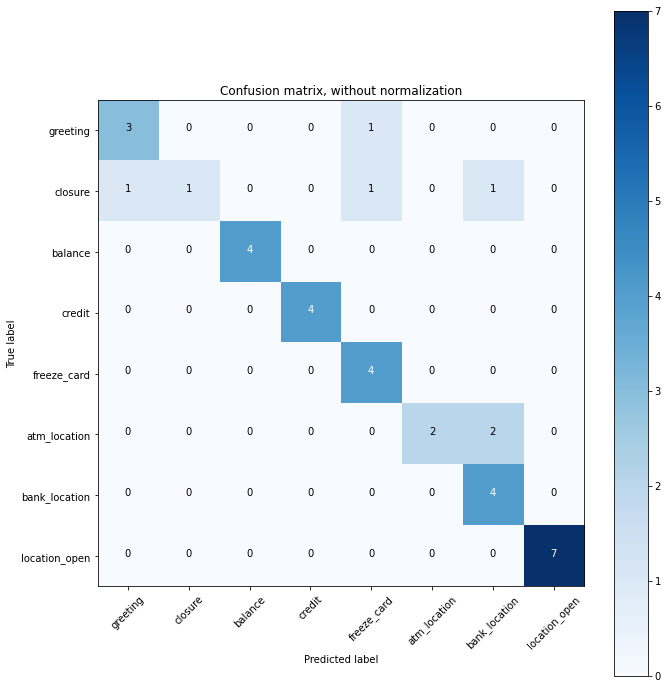

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Copy-paste matplotlib tévesztési mátrix kód
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

y_true = eval_df.intent.tolist()
y_pred = eval_df.predicted.tolist()

cnf_matrix = confusion_matrix(y_true, y_pred, labels=list(eval_df.intent.unique()))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=list(eval_df.intent.unique()),
                      title='Confusion matrix, without normalization')

Az entitás kinyerés kiértékelése nem tartalmaz túl sok infót, mert nem különböztettük meg a bankfiókokat külön entitásként, illetve nem adtunk meg egyéb entitásokat.


In [28]:
print(evaluation_output['entity_evaluation']['DIETClassifier']['report'])

               precision    recall  f1-score   support

bank_location       0.86      1.00      0.92         6

    micro avg       0.86      1.00      0.92         6
    macro avg       0.86      1.00      0.92         6
 weighted avg       0.86      1.00      0.92         6



## Beszélgetés a chatbottal

Ez egy kicsit komplikált notebookban, a példánál használt `chat` függvény nem működik, ha custom actiont is futtatunk...

Lépések:


1. Az action server hajtja végre a custom action-eket. Lehetne egy külön szereveren is (pl céges tűzfal mögött védve), de mi most indítsuk el a `nohup`-pal itt (`rasa run actions`). Így ez a háttérben fog futni és közben a chatbot process tudja hívni...
2. adjuk meg az endpoints.yml-ben, hogy hol fut az action szerver
3. indítsuk el a beszélgetést (`rasa shell`), sajnos az általunk gépelt input nem mindig látszik így, célszerű bemásolni egy szomszédos cellából. A beszélgetést a `/stop`-pal zárjuk le
4. listázzuk ki a futó folyamatokat, keressük meg a `python3 -m rasa run actions` nevű folyamatot
5. a `kill`-el állítsuk le az action szervert

In [29]:
%rm nohup.out

rm: cannot remove 'nohup.out': No such file or directory


Indítsuk el a szervert a háttérben...

In [30]:
!nohup python3 -m rasa run actions &

nohup: appending output to 'nohup.out'


...várjunk pár másodpercet, amig elindul a szerver, majd nézzünk bele a logokba:

In [31]:
!cat nohup.out

2021-04-25 16:12:48 INFO     rasa_sdk.endpoint  - Starting action endpoint server...
2021-04-25 16:12:48 INFO     rasa_sdk.executor  - Registered function for 'action_location_open'.
2021-04-25 16:12:48 INFO     rasa_sdk.executor  - Registered function for 'action_get_balance'.
2021-04-25 16:12:48 INFO     rasa_sdk.endpoint  - Action endpoint is up and running on http://localhost:5055


Adjuk meg, hogy hol éri el a custom action-öket végrehajtó imént elindított szervert a Rasa:

In [32]:
%%writefile endpoints.yml

action_endpoint:
  url: "http://localhost:5055/webhook"

Writing endpoints.yml


Indítsuk el a chatbotot. Várjunk amíg a zöld szöveg megjelenik arról, hogy a bot betöltött. Sajnos ez nem működik túl szépen notebookos terminálban. A beszélgetést a `/stop`-pal állíthatjuk le.

*   Mikor van nyitva a szegedi fiók?
*   Mi a nyitvatartásuk?
*   le szeretném tiltani a kártyám
*   mennyi az egyenlegem?
*   stb...



In [33]:
!python3 -m rasa shell

2021-04-25 16:13:09 INFO     root  - Generating grammar tables from /usr/lib/python3.7/lib2to3/Grammar.txt
2021-04-25 16:13:09 INFO     root  - Generating grammar tables from /usr/lib/python3.7/lib2to3/PatternGrammar.txt
2021-04-25 16:13:10 INFO     root  - Starting Rasa server on http://localhost:5005
tcmalloc: large alloc 1368014848 bytes == 0x5645955fe000 @  0x7f05a380b1e7 0x7f059d9f946e 0x7f059da4de7c 0x7f059da4eaaf 0x7f059daf0470 0x5645700510e4 0x564570050de0 0x5645700c56f5 0x5645700bfb0e 0x56457005277a 0x5645700c186a 0x5645700bfb0e 0x5645700c89fc 0x7f051ef2de28 0x7f051ef37514 0x5645700517f2 0x5645700c4d75 0x7f051ef2b940 0x7f051ef2df3f 0x7f051ef39346 0x56456ff92337 0x7f052040faea 0x564570051050 0x56457014299d 0x5645700c4fe9 0x5645700bfe0d 0x56457005277a 0x5645700c0a45 0x56457005269a 0x5645700c4e50 0x5645700bfe0d
2021-04-25 16:13:26 INFO     rasa.nlu.components  - Added 'SpacyNLP' to component cache. Key 'SpacyNLP-hu'.
2021-04-25 16:13:26.614813: E tensorflow/stream_executor/cuda/c

Állítsuk le az action szervert is. Mivel a háttérben fut, meg kell keresnünk hogy hol... Keressük a `python3 -m rasa run actions` commandot.

In [34]:
%%sh
ps -ef

UID          PID    PPID  C STIME TTY          TIME CMD
root           1       0  1 15:59 ?        00:00:10 /tools/node/bin/node /datalab/web/app.js
root          15       0  0 15:59 ?        00:00:00 tail -n +0 -F /root/.config/Google/DriveFS/Logs/dpb.txt /root/.config/Google/DriveFS/Logs/drive_fs.txt
root          47       1  2 15:59 ?        00:00:25 /usr/bin/python2 /usr/local/bin/jupyter-notebook --ip="172.28.0.2" --port=9000 --FileContentsManager.root_dir="/" --LargeFileManager.delete_to_trash=False --MappingKernelManager.root_dir="/content"
root          48       1  0 15:59 ?        00:00:01 /usr/local/bin/dap_multiplexer --domain_socket_path=/tmp/debugger_k7v1pz2r4
root          59      47 34 15:59 ?        00:04:54 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-fe17e8f7-f4e2-4477-ba2f-04ecb630a48a.json
root          79       1  0 15:59 ?        00:00:03 /usr/bin/python3 /usr/local/lib/python3.7/dist-packages/debugpy/adapter --for-server 461

...másoljuk ki a hozzá tartozó process id-t (PID) és lőjjük le.

In [35]:
%%sh
kill 2453